In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import time

# import functions for ODE parameter estimation
from bayes_ode import *
import jax.numpy as jnp

np.random.seed(123)

## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [2]:
# using gLV model as an example
def system(x, t, u, params): 
    
    # reshape parameters
    r = params[:n_s]
    A = jnp.reshape(params[n_s:], [n_s, n_s])
    
    # constrained gLV 
    return x * (r + A@x) 

## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [3]:
# data from https://www.nature.com/articles/s41467-024-51062-w
df = pd.read_csv("data/MS008_processed.csv")
df = pd.concat([df_i for exp_name, df_i in df.groupby("Treatments") if "Mono" not in exp_name])
df

,Treatments,Time,CA,BT,BU,CS,CD,DP,CH,BV
87,CH-DP-BT-BU,0.0,0.000000,0.002500,0.002500,0.0,0.000000,0.002500,0.002500,0.000000
88,CH-DP-BT-BU,12.0,0.000000,0.726639,0.316787,0.0,0.000000,0.036658,0.111416,0.000000
89,CH-DP-BT-BU,24.0,0.000000,0.633990,0.211766,0.0,0.000000,0.064840,0.106737,0.000000
90,CH-DP-BU-CA,0.0,0.002500,0.000000,0.002500,0.0,0.000000,0.002500,0.002500,0.000000
91,CH-DP-BU-CA,12.0,0.002391,0.000000,0.890796,0.0,0.000000,0.055984,0.142329,0.000000
...,...,...,...,...,...,...,...,...,...,...
82,MS008-DP-BT-BU-BV-CA,12.0,0.003568,0.752347,0.126277,0.0,0.307087,0.041542,0.000000,0.142012
83,MS008-DP-BT-BU-BV-CA,24.0,0.065093,0.771636,0.155679,0.0,0.055671,0.103377,0.000000,0.055543
84,MS008-DP-BU-CA,0.0,0.002500,0.000000,0.002500,0.0,0.002500,0.002500,0.000000,0.000000
85,MS008-DP-BU-CA,12.0,0.006165,0.000000,0.469328,0.0,0.415756,0.049418,0.000000,0.000000


## Specify system state variables 

In [4]:
# names of species
species = df.columns.values[2:]
inputs = []

# global parameters used in ODE
n_s = len(species)

## Define mean and standard deviation of Gaussian parameter prior 

In [5]:
# define initial parameter guess
n_params = n_s + n_s**2 
params = np.zeros(n_params)

# initial guess of growth rates
params[:n_s] = .3

# initial guess of self interaction terms
k = 0
for i in range(n_s):
    for j in range(n_s):
        if i == j:
            params[n_s+k] = -1.
        k += 1

# mean of parameter prior is zero
prior = np.zeros(n_params)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [6]:
# instantiate gLV fit 
model = Model(system = system, 
              dataframe = df, 
              sys_vars = species,
              inputs = inputs,
              params = params,
              prior = prior, 
              alpha=1., nu2=.001, sigma2=.001)

## Fit the parameter posterior

In [7]:
# fit to data 
t0 = time.time()

model.fit_posterior_EM(lr=1e-3,
                       n_sample_sgd=3, 
                       n_sample_hypers=100,
                       patience=3)

print("Elapsed time {:.2f}s".format(time.time()-t0))

Updating posterior...
Epoch 0, ELBO: -18685.680, Slope: 1.000, Convergence: 0.00000
Epoch 5, ELBO: -2452.257, Slope: 1.000, Convergence: 0.76798
Epoch 10, ELBO: -409.751, Slope: 0.158, Convergence: 0.94295
Epoch 15, ELBO: 293.435, Slope: 0.166, Convergence: 1.05522
Epoch 20, ELBO: 664.036, Slope: 0.170, Convergence: 1.16125
Epoch 25, ELBO: 875.847, Slope: 0.172, Convergence: 1.26656
Epoch 30, ELBO: 1029.344, Slope: 0.173, Convergence: 1.38562
Epoch 35, ELBO: 1189.563, Slope: 0.162, Convergence: 1.54394
Epoch 40, ELBO: 1289.105, Slope: 0.147, Convergence: 1.71589
Epoch 45, ELBO: 1380.117, Slope: 0.132, Convergence: 1.93086
Epoch 50, ELBO: 1447.781, Slope: 0.235, Convergence: 1.72795
Epoch 55, ELBO: 1507.150, Slope: 0.115, Convergence: 0.62643
Epoch 60, ELBO: 1559.408, Slope: 0.073, Convergence: 0.38789
Epoch 65, ELBO: 1606.204, Slope: 0.053, Convergence: 0.27999
Epoch 70, ELBO: 1634.087, Slope: 0.041, Convergence: 0.20877
Epoch 75, ELBO: 1677.947, Slope: 0.034, Convergence: 0.17169
Epoc

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 59.01it/s]


Updating posterior...
Epoch 0, ELBO: 2508.979, Slope: 1.000, Convergence: 0.00000
Epoch 5, ELBO: 2551.147, Slope: 1.000, Convergence: 0.00833
Epoch 10, ELBO: 2559.683, Slope: 0.002, Convergence: 0.00777
Epoch 15, ELBO: 2559.613, Slope: 0.002, Convergence: 0.00580
Epoch 20, ELBO: 2568.693, Slope: 0.002, Convergence: 0.00748
Epoch 25, ELBO: 2575.755, Slope: 0.003, Convergence: 0.00853
Epoch 30, ELBO: 2580.023, Slope: 0.003, Convergence: 0.00873
Epoch 35, ELBO: 2580.601, Slope: 0.003, Convergence: 0.00783
Epoch 40, ELBO: 2577.087, Slope: 0.002, Convergence: 0.00573
Epoch 45, ELBO: 2582.555, Slope: 0.002, Convergence: 0.00707
Epoch 50, ELBO: 2588.374, Slope: 0.001, Convergence: 0.00623
pass 1
Epoch 55, ELBO: 2585.782, Slope: 0.001, Convergence: 0.00387
pass 2
Epoch 60, ELBO: 2585.997, Slope: 0.001, Convergence: 0.00293
pass 3
Epoch 65, ELBO: 2592.289, Slope: 0.001, Convergence: 0.00410
Updating hyperparameters...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 70.23it/s]


Updating posterior...
Epoch 0, ELBO: 2596.500, Slope: 1.000, Convergence: 0.00000
Epoch 5, ELBO: 2601.685, Slope: 1.000, Convergence: 0.00100
pass 1
Epoch 10, ELBO: 2603.751, Slope: 0.000, Convergence: 0.00119
pass 2
Epoch 15, ELBO: 2602.994, Slope: 0.000, Convergence: 0.00068
pass 3
Epoch 20, ELBO: 2604.034, Slope: 0.000, Convergence: 0.00086
Updating hyperparameters...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 64.24it/s]


Updating posterior...
Epoch 0, ELBO: 2568.183, Slope: 1.000, Convergence: 0.00000
Epoch 5, ELBO: 2567.688, Slope: 1.000, Convergence: -0.00010
pass 1
Epoch 10, ELBO: 2572.354, Slope: 0.000, Convergence: 0.00115
pass 2
Epoch 15, ELBO: 2574.088, Slope: 0.000, Convergence: 0.00137
pass 3
Epoch 20, ELBO: 2571.276, Slope: 0.000, Convergence: 0.00022
Updating hyperparameters...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.49it/s]


Updating posterior...
Epoch 0, ELBO: 2588.429, Slope: 1.000, Convergence: 0.00000
Epoch 5, ELBO: 2594.574, Slope: 1.000, Convergence: 0.00119
pass 1
Epoch 10, ELBO: 2591.647, Slope: 0.000, Convergence: 0.00004
pass 2
fail 1
Epoch 15, ELBO: 2587.977, Slope: -0.000, Convergence: -0.00103
pass 3
Epoch 20, ELBO: 2596.597, Slope: 0.000, Convergence: 0.00183
Updating hyperparameters...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 48.03it/s]


Updating posterior...
Epoch 0, ELBO: 2579.810, Slope: 1.000, Convergence: 0.00000
Epoch 5, ELBO: 2577.155, Slope: 1.000, Convergence: -0.00051
pass 1
Epoch 10, ELBO: 2582.620, Slope: 0.000, Convergence: 0.00107
pass 2
Epoch 15, ELBO: 2580.600, Slope: 0.000, Convergence: 0.00021
pass 3
Epoch 20, ELBO: 2580.582, Slope: 0.000, Convergence: 0.00017
Updating hyperparameters...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 56.68it/s]


Updating posterior...
Epoch 0, ELBO: 2580.270, Slope: 1.000, Convergence: 0.00000
Epoch 5, ELBO: 2573.178, Slope: 1.000, Convergence: -0.00138
pass 1
fail 1
Epoch 10, ELBO: 2574.385, Slope: -0.000, Convergence: -0.00061
pass 2
fail 2
Epoch 15, ELBO: 2577.116, Slope: -0.000, Convergence: 0.00034
pass 3
Epoch 20, ELBO: 2580.542, Slope: 0.000, Convergence: 0.00134
Elapsed time 139.26s


In [8]:
model.nu2

array([0.00023079, 0.0001    , 0.0001    , 0.00027408, 0.0071679 ,
       0.0001    , 0.00133794, 0.00524985])

In [9]:
model.sigma2

array([0.28112805, 0.03144378, 0.08855867, 0.01912794, 0.04265814,
       0.2240992 , 0.01907084, 0.06057999])

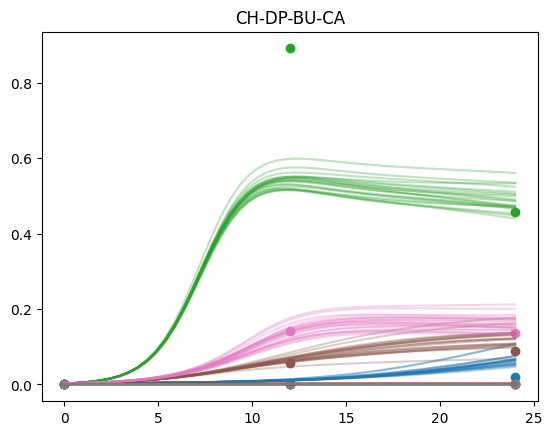

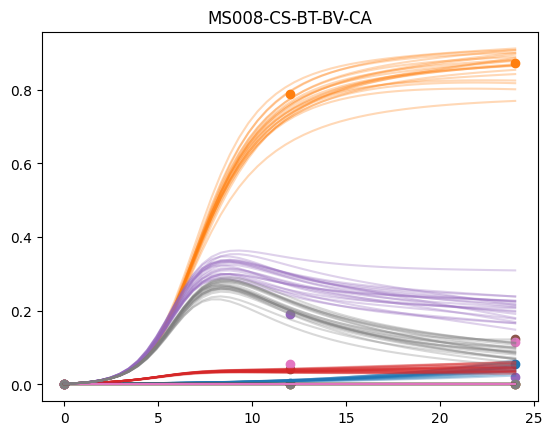

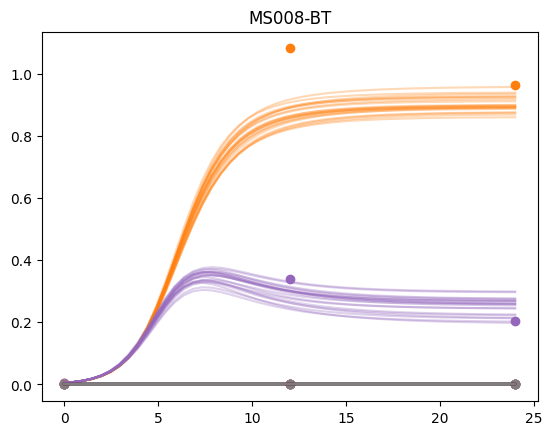

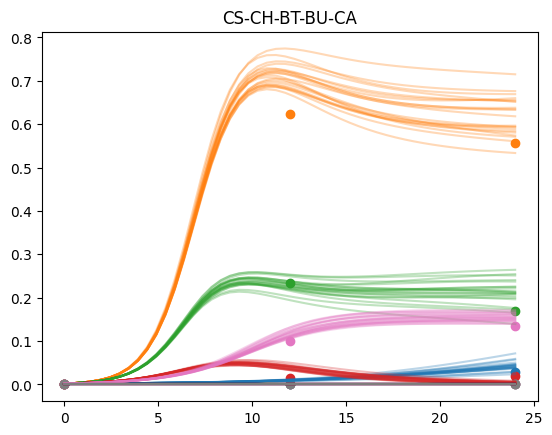

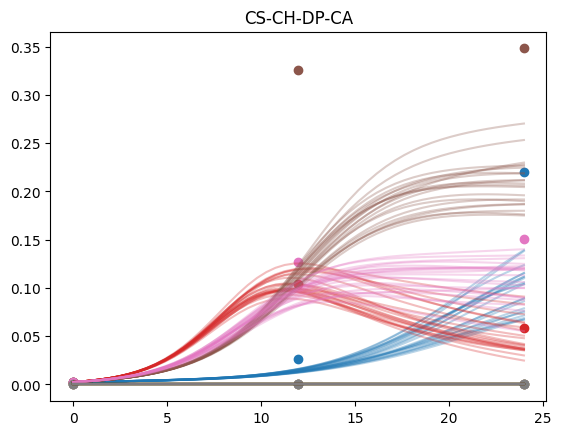

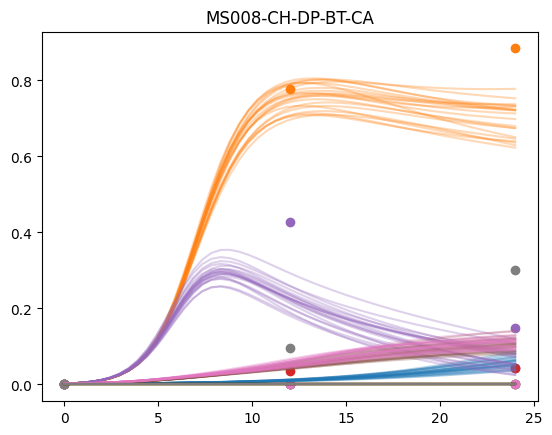

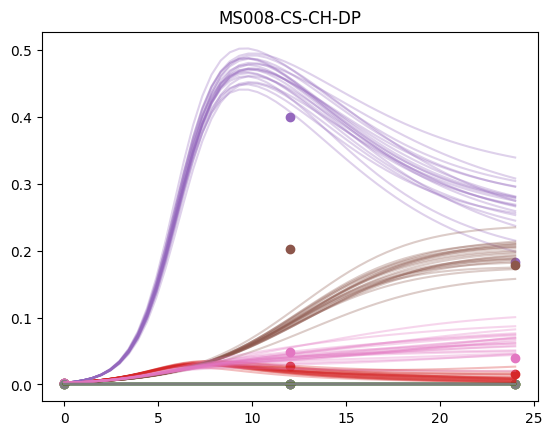

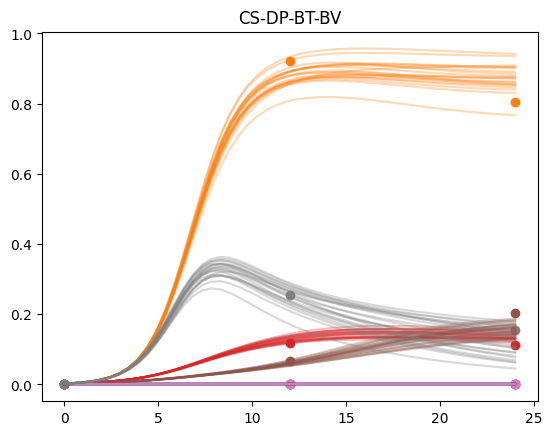

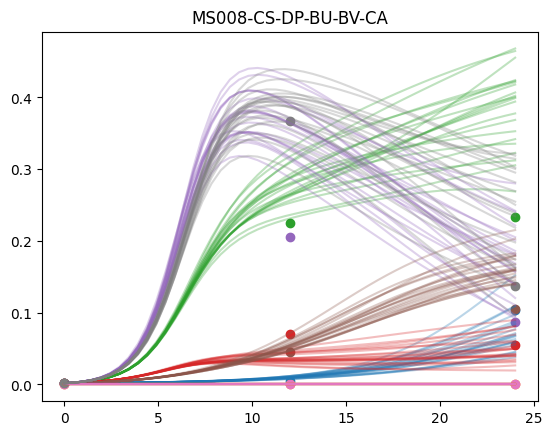

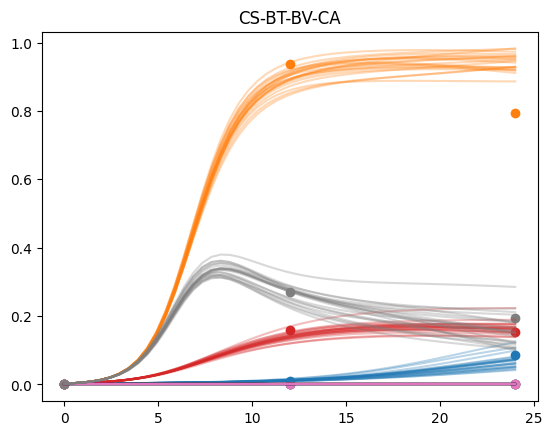

In [12]:
# random conditions to plot
plt_conditions = np.random.choice(np.unique(df.Treatments.values), 10, replace=False)

for exp_name in plt_conditions:
    # pull dataframe
    exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    u = np.array([])
    t_eval = np.linspace(0., max(exp_df.Time.values))
    y_preds = model.predict_sample(x0, u, t_eval)

    # plot 
    for i, s in enumerate(species):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

## Save parameter values

In [11]:
# Define names of parameters 
df_params = model.param_df()
df_params

,mean,stdv
0,0.111785,0.005516
1,0.876827,0.005412
2,0.763594,0.004778
3,0.519388,0.005734
4,0.912009,0.012850
...,...,...
67,0.643469,0.178464
68,-0.521565,0.066484
69,-1.192569,0.221838
70,-0.659505,0.097732
